# Largest Rectangle under a histogram

This is a popular coding interview question. It's really simple with a simple histogram using pen and paper, but harder to think about in code, as it takes a bit of thinking through.

Detailed problem description: https://leetcode.com/problems/largest-rectangle-in-histogram/

A few test arrays with the largest area:

In [9]:
# | echo: false
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

In [22]:
tests = (
    ([2, 1, 5, 6, 2, 3], 10),
    ([6, 3, 1, 4, 12, 4], 12),
    ([5, 6, 7, 4, 1], 16),
    ([2, 1, 3, 4, 1], 6),
)

The arrays are visualized below, which makes it much easier to think about the solution. I found it easier to do it on paper first, before coding.

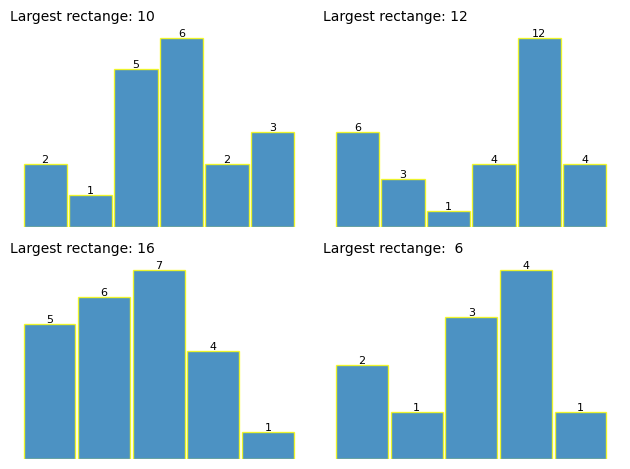

In [11]:
# | code-fold: true
# | echo: true
fig, axes = plt.subplots(2, 2, layout="tight")
for ax, (arr, ans) in zip(axes.flatten(), tests):
    ax.set_axis_off()
    bar = ax.bar(
        range(len(arr)),
        arr,
        width=0.95,
        alpha=0.8,
        edgecolor="yellow",
    )
    ax.set_title(f"Largest rectange: {ans:2}", loc="left", fontsize=10)
    ax.bar_label(bar, fontsize=8)

Looking at the array makes it easy to see where the largest rectangle might be.

## A simple solution

We can brute force this by generating the largest possible rectangle at every item in the array.

For each N in the arry:

- find the left and right boundary of the largest possible rectangle
- this gives us the width, exluding the width of N itself (adding 1 to ad back N)
- so now we have the width, and the height is just the value N in the array

To keep things simple, first up a helper function which returns the rectangle boundaries of a given point in an array:


In [28]:
def find_boundary(idx: int, arr: list[int]) -> tuple[int, int]:
    """
    Example:
        idx 2 for [2, 1, 5, 6, 2, 3] returns (2, 3)
    Returns:
        (left, right)
    """

    # find left boundary (can be itself)
    left = 0
    if idx == left:
        pass  # deals with the left edge
    else:
        # march leftwards all the way to zero:
        for j in range(idx - 1, -1, -1):
            if arr[j] < arr[idx]:
                left = j + 1  # adding 1 to exlude boundary
                break  # exit loop once the first boundary found

    # find right boundary (can be itself)
    right = len(arr) - 1  # deal with the right edge

    if idx == right:
        pass  # at right edge already
    else:
        # march rightwards
        for j in range(idx, len(arr)):
            if arr[j] < arr[idx]:
                right = j - 1  # subtracting 1 to exclude boundary
                break

    return left, right

Phew! that should return the `(left, right)` boundaries for a given index and array.

I drew the boundaries by hand for the first array to test the algo:

In [41]:
# testing this for the first arrary in the tests
for arr, ans in tests:
    print("array: ", arr)
    for i in range(len(arr)):
        print(f"Index {i}: (val {arr[i]}) - Boundaries: {find_boundary(i, arr)}")
    break

array:  [2, 1, 5, 6, 2, 3]
Index 0: (val 2) - Boundaries: (0, 0)
Index 1: (val 1) - Boundaries: (0, 5)
Index 2: (val 5) - Boundaries: (2, 3)
Index 3: (val 6) - Boundaries: (3, 3)
Index 4: (val 2) - Boundaries: (2, 5)
Index 5: (val 3) - Boundaries: (5, 5)


The `find_boundary` func is working, so now its easy to get the area of the max rectangle.

### Finding the largest rectangle

The below function iterates through every item in the array, calculates the area of the largest rectangle at that point, and updates the max area function.


In [24]:
def max_area(arr: list[int], viz: bool = False) -> int:
    """returns the area of the biggest rectangle,
    and optionally returns its index"""
    max_area = 0
    max_idx = None

    for i in range(len(arr)):
        left, right = find_boundary(i, arr)
        # adding 1 to width as when we calc (right - left) it excludes itself
        width = 1 + right - left

        new_area = arr[i] * width
        if new_area > max_area:
            max_area = new_area
            max_idx = i

    if viz:
        return max_idx, max_area
    else:
        return max_area


for arr, ans in tests:
    assert max_area(arr) == ans
    print(f"{arr} ----> {max_area(arr)}")
print(f"all {len(tests)} tests passed!")

[2, 1, 5, 6, 2, 3] ----> 10
[6, 3, 1, 4, 12, 4] ----> 12
[5, 6, 7, 4, 1] ----> 16
[2, 1, 3, 4, 1] ----> 6
all 4 tests passed!


That was pretty straight forward, though a bit verbose. Now an excercise in plotting this visually:

### Eyeballing the largest rectangle

Using matplotlib to plot the largest rectangle - this helps explain why the answer better than a wall of text.

In [25]:
# to use to show different rectangele with diff colors and fills
colors = list(mcolors.TABLEAU_COLORS.values())
hatches = ["/", "\\", "|", "-", "+", "x", "o", "O", ".", "*"]

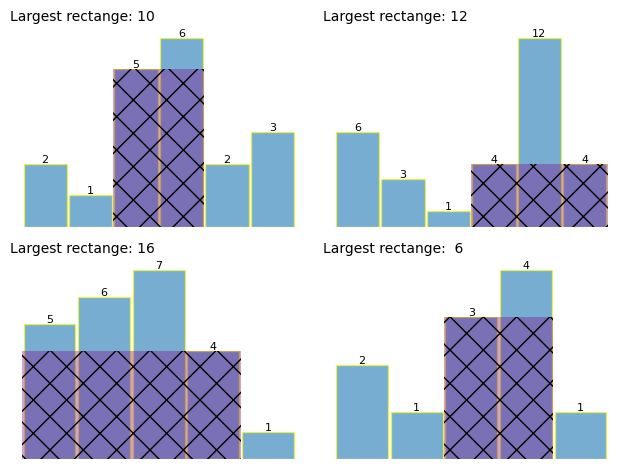

In [26]:
# | code-fold: true
# | echo: true
fig, axes = plt.subplots(2, 2, layout="tight")
for ax, (arr, ans) in zip(axes.flatten(), tests):
    ax.set_axis_off()
    bar = ax.bar(
        range(len(arr)),
        arr,
        width=0.95,
        alpha=0.6,
        edgecolor="yellow",
    )
    ax.set_title(f"Largest rectange: {ans:2}", loc="left", fontsize=10)
    ax.bar_label(bar, fontsize=8)

    idx, area = max_area(arr, True)

    for i in range(len(arr)):
        if i == idx:  # got too messy plotting all the rects
            left, right = find_boundary(i, arr)
            width = 1 + right - left
            ax.add_patch(
                Rectangle(
                    (left - 0.5, 0),
                    width,
                    arr[i],
                    alpha=0.35,
                    facecolor="purple",
                    ls="--",
                    lw=2,
                    hatch=hatches[5],
                )
            )

Every time I use matplotlib I'm both horrified and inmpressed by what you can do it... basically anything but so much code...

## A faster, stack based solution

By using a stack, we can find the largest rect in O(n) time, as we don't go through the array multiple times in this solution.

Instead of relooping through the array, we can use a stack to only go through the array once.

This algo:
* while the stack isn't empty and the height of the current bar is <= to the top bar in the stack
    * calc area, update if bigger
        * height is the bar at the top of the array
    * push current bar onto stack
* the above will leave bars in the stack which only have bigger items to their right. Deal wit this by
    * pop the stack, the height is that item, the width is the distance b/t that item and the end of the array
    * if this area bigger, update max area

In [48]:
def histogram_max_area(arr):
    stack = [-1]  # the stop or sentinel value
    max_area = 0

    for i in range(len(arr)):
        while stack[-1] != -1 and arr[stack[-1]] >= arr[i]:
            current_height = arr[stack.pop()]
            current_width = i - stack[-1] - 1
            max_area = max(max_area, current_height * current_width)
        stack.append(i)

    # the remaining stack items rectangles extend all the way to the end
    while stack[-1] != -1:
        current_height = arr[stack.pop()]
        current_width = len(arr) - stack[-1] - 1
        max_area = max(max_area, current_height * current_width)
    return max_area


for arr, ans in tests:
    assert histogram_max_area(arr) == ans
    print(f"{arr} ----> {ans}")
    break

print(f"all {len(tests)} tests passed!")

[2, 1, 5, 6, 2, 3] ----> 10
all 4 tests passed!
